In [1]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns

from sklearn.model_selection import train_test_split
%pip install -qq --upgrade ucimlrepo
from ucimlrepo import fetch_ucirepo
from ipywidgets import interact
from functools import partial

np.random.seed(13)
sns.set_theme(style="ticks")

Note: you may need to restart the kernel to use updated packages.


# Zadanie 1

In [2]:
iris = fetch_ucirepo(id=53)

X = iris.data.features
y = iris.data.targets

## 1.1

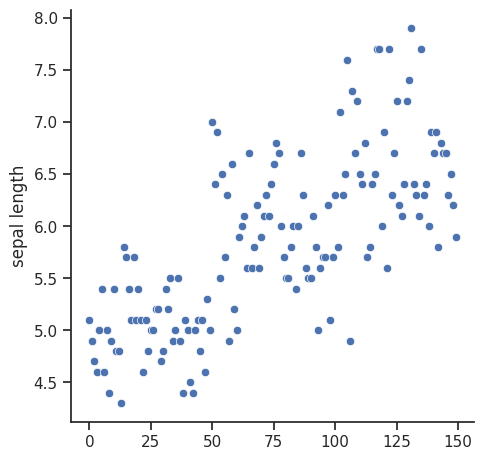

In [3]:
_ = sns.relplot(X['sepal length'])

## 1.2

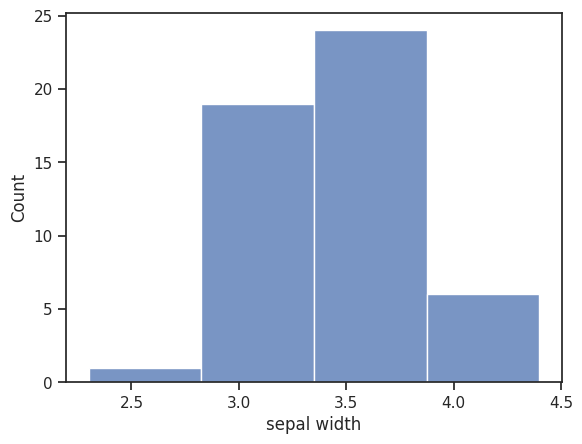

In [4]:
_ = sns.histplot(X[y['class'] == 'Iris-setosa']['sepal width'], binwidth=0.5)

## 1.3
Gatunek Setosa jest liniowo separowalny od pozostałych dwóch gatunków.

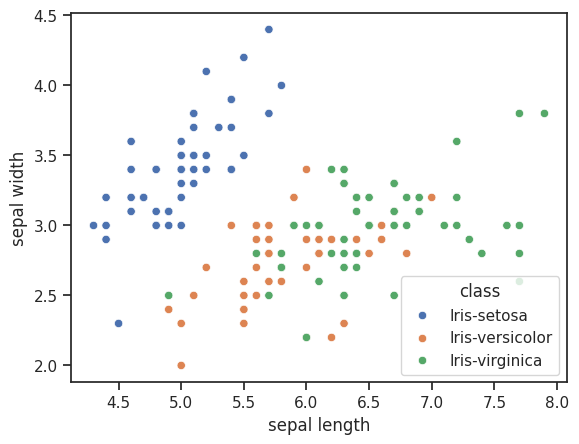

In [5]:
_ = sns.scatterplot(X.join(y), x='sepal length', y='sepal width', hue='class')

## 1.4

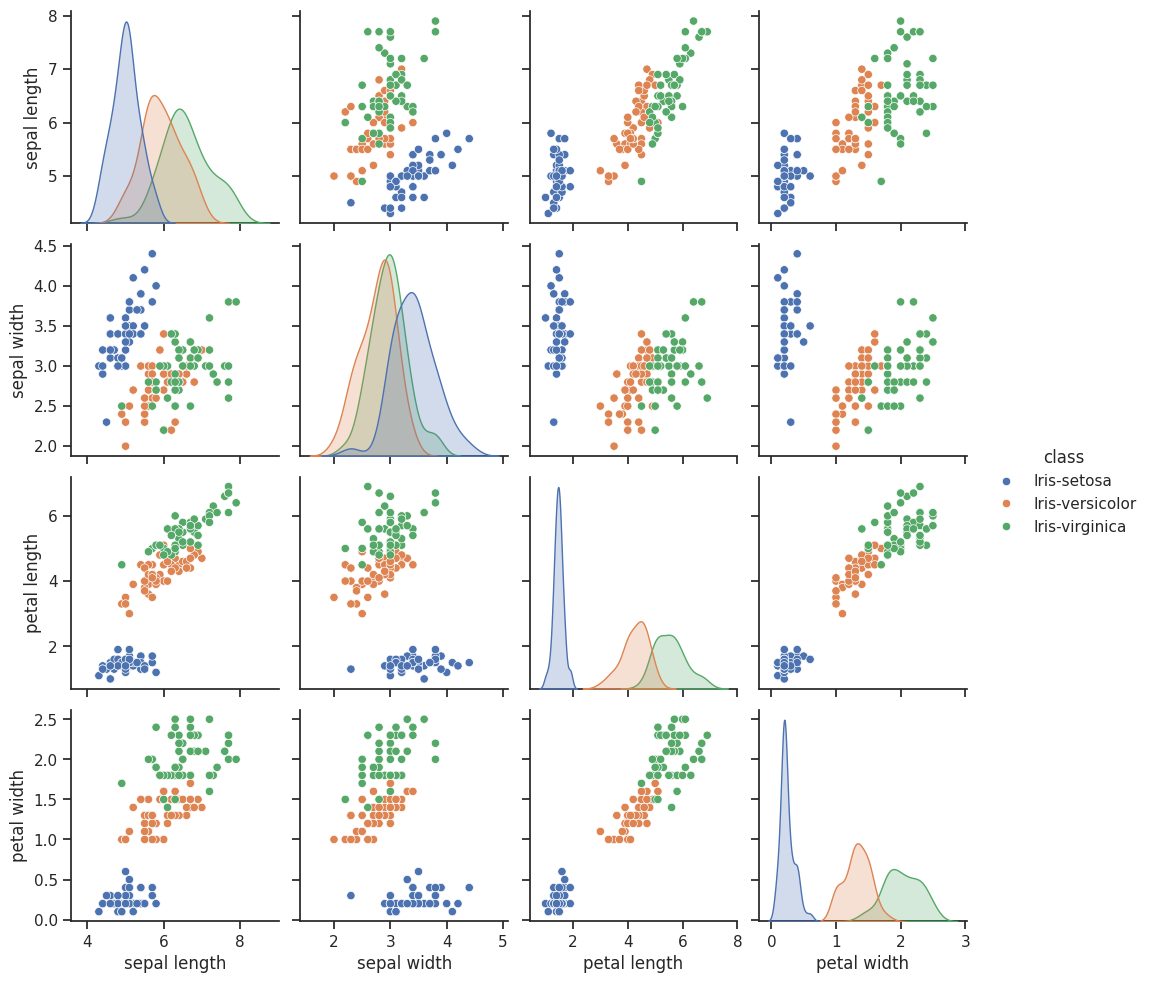

In [6]:
_ = sns.pairplot(data=X.join(y), hue="class")

## 1.5

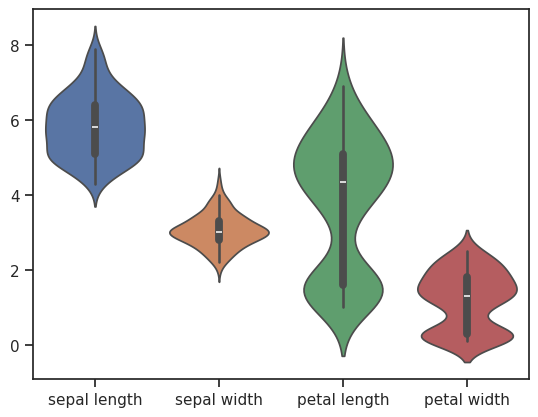

In [7]:
_ = sns.violinplot(X)

# Zadanie 2

In [8]:
bank_marketing = fetch_ucirepo(id=222)

X = bank_marketing.data.features
y = bank_marketing.data.targets

## 2.1
Widzimy, że niezainteresowani klienci często bardzo szybko odmawiali.

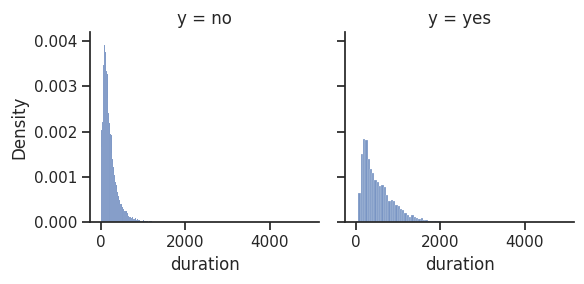

In [9]:
g = sns.FacetGrid(X.join(y), col='y')
_ = g.map(partial(sns.histplot, stat='density'), "duration")

## 2.2

In [10]:
def plot(age):
    sns.histplot(X[X['age'] > age]['balance'], bins=50)

_ = interact(plot, age=widgets.IntSlider(value=25, min=X['age'].min(), max=X['age'].max()-1))

interactive(children=(IntSlider(value=25, description='age', max=94, min=18), Output()), _dom_classes=('widget…

## 2.3
Na początku widzimy monotoniczny wzrost prawdopodobieństwa, że próbka jest 
pozytywna, wraz z czasem trwania rozmowy. Później wykres się "psuje", 
prawdopodobnie ze względu na duży szum spowodowany zbyt małymi rozmiarami próbek.

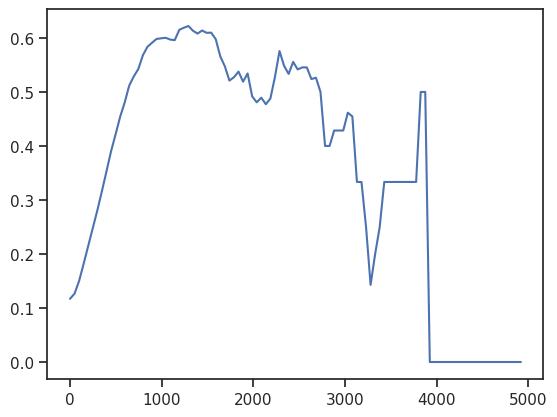

In [11]:
@np.vectorize
def percentage(t, atr):
    samples = X.join(y)[X[atr] >= t]
    return np.sum(samples['y'] == 'yes') / samples['y'].size

x = np.linspace(0, X['duration'].max(), 100)
_ = sns.lineplot(x=x, y=percentage(x, atr='duration'))

## 2.4
Na pierwszy rzut oka powinniśmy się kontaktować z klientami o saldzie powyżej ~70000. Jednak 
jednostajność rozkładu powyżej progu jest trochę podejrzana i wydaje mi się, że znowu mamy do 
czynienia z outlierami. Lepiej będzie wybrać rozkład jednostajny dla wszystkich próbek.

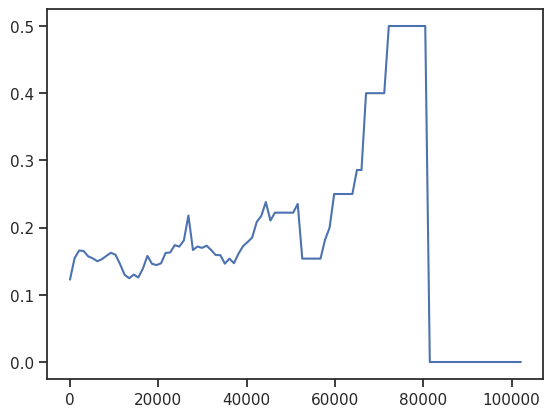

In [12]:
x = np.linspace(0, X['balance'].max(), 100)
_ = sns.lineplot(x=x, y=percentage(x, atr='balance'))

## 2.5

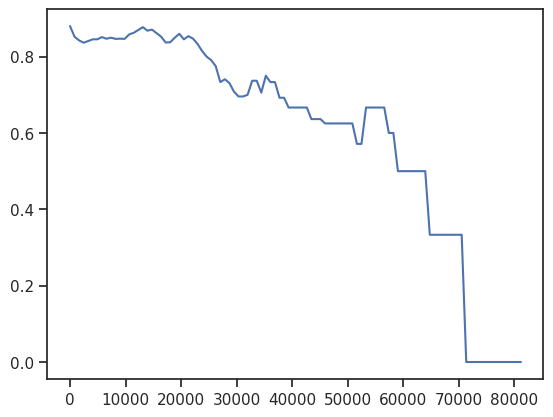

In [13]:
train, test = train_test_split(X.join(y), test_size=0.5)

@np.vectorize
def train_fn(t):
    samples = train[train['balance'] >= t]
    return np.sum(samples['y'] == 'no') / samples['y'].size

x = np.linspace(0, train['balance'].max(), 100)
_ = sns.lineplot(x=x, y=train_fn(x))

#### Na podstawie powyższego wykresu ustalamy próg na ~65000.

In [14]:
T = 65000

samples = train[train['balance'] >= T]
accuracy = np.sum(samples['y'] == 'no') / samples['y'].size

print(f"{accuracy:.2%} nie było zainteresowanych.")

interested = train[train['balance'] <= T]
p = np.sum(interested['y'] == 'yes') / np.sum(train['y'] == 'yes')

print(f"{p:.3%} zainteresowanych miało saldo poniżej progu.")

33.33% nie było zainteresowanych.
99.923% zainteresowanych miało saldo poniżej progu.


#### Nasz próg sprawdza się beznadziejnie dla danych testowych, co było do przewidzenia.

In [15]:
samples = test[test['balance'] >= T]
accuracy = np.sum(samples['y'] == 'no') / samples['y'].size

print(f"{accuracy:.2%} nie było zainteresowanych.")

interested = test[test['balance'] <= T]
p = np.sum(interested['y'] == 'yes') / np.sum(test['y'] == 'yes')

print(f"{p:.3%} zainteresowanych miało saldo poniżej progu.")

100.00% nie było zainteresowanych.
100.000% zainteresowanych miało saldo poniżej progu.


#### Mierząc dokładność progu względem całkowitej liczby próbek, widzimy że prawdopodobieństwo próbki pozytywnej nie jest zbytnio powiązane z saldem. Możemy wywnioskować, że najlepiej będzie użyć progu T >= 0:

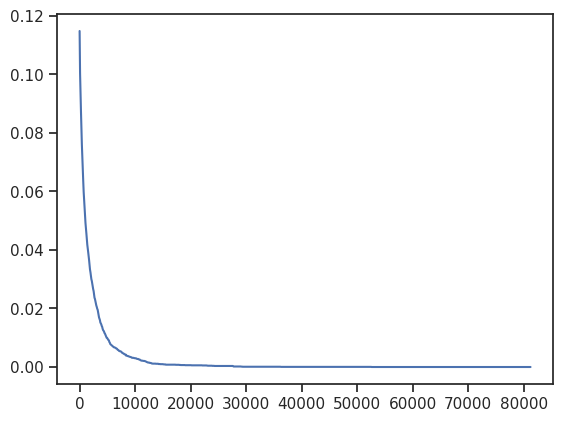

In [16]:
@np.vectorize
def thresh_accuracy(t):
    samples = test[test['balance'] >= t]
    return np.sum(samples['y'] == 'yes') / test['y'].size

x = np.linspace(0, train['balance'].max(), 1000)
_ = sns.lineplot(x=x, y=thresh_accuracy(x))

# Zadanie 3

In [17]:
car_evaluation = fetch_ucirepo(id=19)

X = car_evaluation.data.features
y = car_evaluation.data.targets

## 3.1

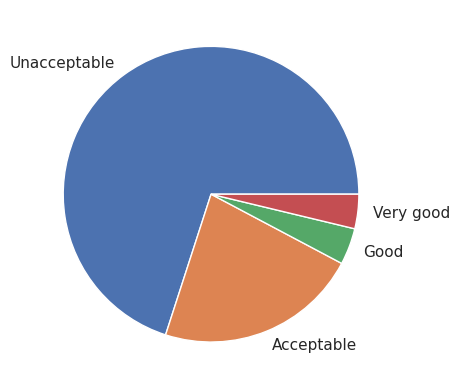

In [18]:
labels = {'unacc': 'Unacceptable', 'vgood': 'Very good', 'good': 'Good', 'acc': 'Acceptable'}

s = y['class'].value_counts()
_ = plt.pie(s, labels=s.index.map(labels))

## 3.2

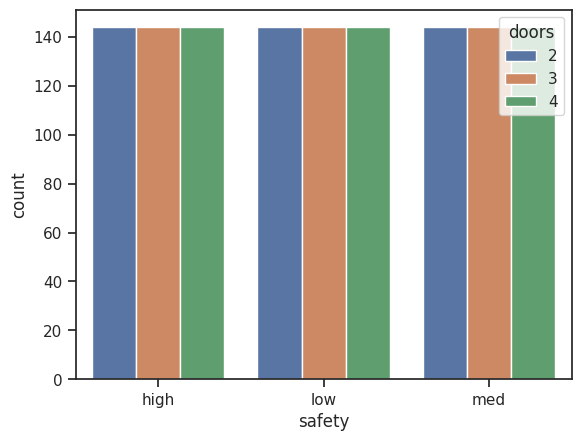

In [19]:
s = X.value_counts(['safety', 'doors']).reset_index(name='count')
s = s[s['doors'].isin(['2', '3', '4'])]
_ = sns.barplot(s, x='safety', y='count', hue='doors', errorbar=None)

## 3.3

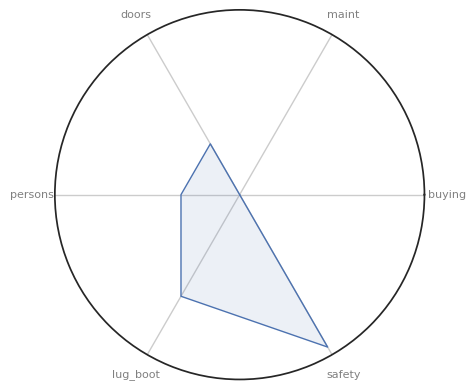

In [20]:
values = X.loc[0].values.flatten().tolist()
values += values[:1]
 
categories = list(X)
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]
 
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='grey', size=8)

ax.set_rlabel_position(0)
plt.yticks([])
 
ax.plot(angles, values, linewidth=1, linestyle='solid')
ax.fill(angles, values, 'b', alpha=0.1)

plt.show()

# Zadanie 4

## 4.1 i 4.2

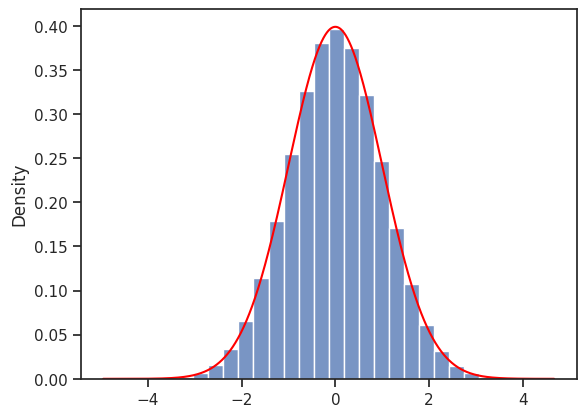

In [21]:
y = np.random.randn(1_000_000)
ax = sns.histplot(y, bins=30, stat="density")

@np.vectorize
def pdf(x):
    return np.exp(-0.5 * x**2) / np.sqrt(2*np.pi)

x = np.linspace(y.min(), y.max(), y.size)
_ = sns.lineplot(x=x, y=pdf(x), color='red', ax=ax)

## 4.3
Metoda z zadania 1.3 nie zadziała. Widzimy, że zbiory nachodzą na siebie i już nie są liniowo separowalne.

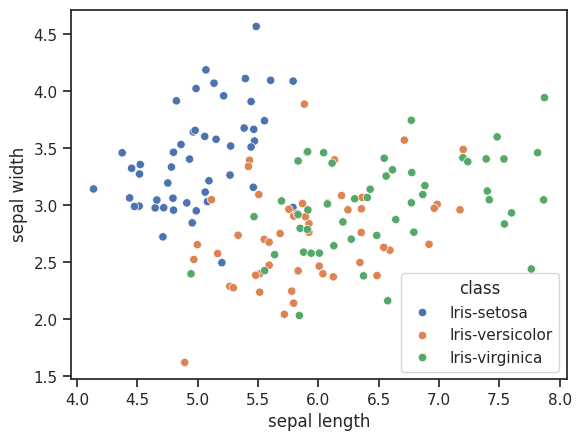

In [22]:
iris = fetch_ucirepo(id=53)

X = iris.data.features
y = iris.data.targets

X.loc[:, 'sepal length'] += np.random.normal(scale=0.25, size=X['sepal length'].size)
X.loc[:, 'sepal width'] += np.random.normal(scale=0.25, size=X['sepal width'].size)

_ = sns.scatterplot(X.join(y), x='sepal length', y='sepal width', hue='class')

# Zadanie 5

## 5.1 i 5.2

In [23]:
def bar(cx, cy, height, width=1.0):
    s = width * 0.6
    vertices = np.array([
        [cx - s, cy - s, 0],
        [cx + s, cy - s, 0],
        [cx + s, cy + s, 0],
        [cx - s, cy + s, 0],
        [cx - s, cy - s, height],
        [cx + s, cy - s, height],
        [cx + s, cy + s, height],
        [cx - s, cy + s, height],
    ])
    x, y, z = vertices.T

    faces = [
        [0, 1, 2, 3],
        [4, 5, 6, 7],
        [0, 4, 7, 3],
        [1, 5, 6, 2],
        [3, 2, 6, 7],
        [0, 1, 5, 4],
    ]
    triangles = np.array([f[:-1] for f in faces] + [f[:1] + f[2:] for f in faces])
    i, j, k = triangles.T

    return (x, y, z), (i, j, k)

def histogram3d(points, bins=50):
    hist, xedges, yedges = np.histogram2d(*points, bins=bins, density=True)
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')

    width = np.ptp(xpos) / bins
    bars = [bar(*coords, width=width) for coords in zip(*map(np.ravel, (xpos, ypos, hist)))]
    vert, idx = [np.array(t).swapaxes(0, 1) for t in zip(*bars)]
    idx += np.arange(idx.shape[1])[None, :, None] * vert.shape[2]

    (x, y, z), (i, j, k) = [x.reshape(3, -1) for x in (vert, idx)]
    bars = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, color='black')
    return bars, (width, xpos, ypos)


points = np.random.randn(2, 1_000_000)
bars, (width, xpos, ypos) = histogram3d(points)

@np.vectorize
def pdf(x, y):
    return np.exp(-0.5 * (x**2 + y**2)) / (2 * np.pi)

s = width / 2.0
z = pdf(xpos + s, ypos + s)

fig = go.Figure([go.Surface(x=xpos, y=ypos, z=z, opacity=0.8), bars])
fig.update_layout(
    title="Comparison between histogram and density plot of a normal distribution",
    width=600, height=500,
    scene_camera=dict(
        eye=dict(x=1.0, y=1.0, z=1.0)
    ),
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='p',
    ),
)
fig.show()